# Fitting radial velocities

In this tutorial we will learn how to use `jaxoplanet` to compute the radial velocities of a star hosting a single exoplanet, and how to fit this dataset using `numpyro`.

In [1]:
# Double precision with JAX
import jax

jax.config.update("jax_enable_x64", True)

## Model and dataset

Let's first generate our dataset, consisting in the radial velocities of a star orbited by a unique exoplanet. We start by defining the system (see [Data and Model]() for more details)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import keplerian

star = keplerian.Central(mass=1.0, radius=1.0)
true_planet = keplerian.Body(mass=0.02, period=3.0)
system = keplerian.System(star, bodies=[true_planet])

As we left many parameters as default, let's check the parameters of the system

In [3]:
system

System(
  central=Central(
    mass=<Quantity(1.0, 'M_sun')>,
    radius=<Quantity(1.0, 'R_sun')>,
    density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
  ),
  bodies=[
    Body(
      central=Central(
        mass=<Quantity(1.0, 'M_sun')>,
        radius=<Quantity(1.0, 'R_sun')>,
        density=<Quantity(0.238732415, 'M_sun / R_sun ** 3')>
      ),
      time_ref=<Quantity(-0.75, 'day')>,
      time_transit=<Quantity(0.0, 'day')>,
      period=<Quantity(3.0, 'day')>,
      semimajor=<Quantity(8.811544073109136, 'R_sun')>,
      sin_inclination=<Quantity(1.0, 'dimensionless')>,
      cos_inclination=<Quantity(0.0, 'dimensionless')>,
      impact_param=<Quantity(0.0, 'dimensionless')>,
      mass=<Quantity(0.02, 'M_sun')>,
      radius=None,
      eccentricity=None,
      sin_omega_peri=None,
      cos_omega_peri=None,
      sin_asc_node=None,
      cos_asc_node=None,
      radial_velocity_semiamplitude=None,
      parallax=None
    )
  ],
  _body_stack=Body(
    central=Central(
 

We can now compute the radial radial_velocities of the star and add some noise to simulate our dataset

<ErrorbarContainer object of 3 artists>

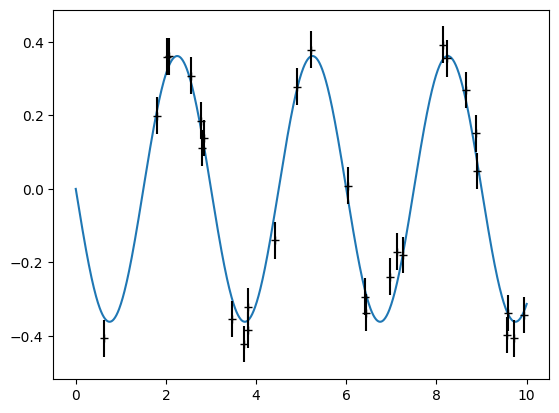

In [9]:
from jaxoplanet.units import unit_registry as ureg

over_time = np.linspace(0, 10, 1000)
over_rvs = system.radial_velocity(over_time)[0]
time = np.sort(np.random.uniform(0, 10, 30))
rv_obs = system.radial_velocity(time)[0]
rv_err = 0.05 * rv_obs.units
rv_obs += rv_err * np.random.normal(size=len(time))

plt.plot(over_time, over_rvs.magnitude)
plt.errorbar(time, rv_obs.magnitude,  yerr=rv_err.magnitude, fmt="+k")

## Inference

In [11]:
import numpyro
import jax.numpy as jnp
from numpyro import distributions as dist, infer

def rv_model(time, params):
    planet = keplerian.Body(mass=params["mass"], period=params["period"])
    system = keplerian.System(central=star, bodies=[planet])
    return system.radial_velocity(time)[0].magnitude

def model(time, y=None):
    mass = numpyro.sample("mass", dist.Uniform(0.01, 0.1))
    period = numpyro.sample("period", dist.Uniform(1.0, 10.0))
    error = numpyro.sample("error", dist.Uniform(0.01, 0.08))
    rv = rv_model(time, {"mass": mass, "period": period})
    numpyro.sample("y", dist.Normal(rv, error), obs=y)

Once the model defined, we will sample the posterior likelihood of the model parameters given the observed radial velocities. As we will need to provide some initial values for these parameters, it is a good idea to check that these values provide a good starting point for the model

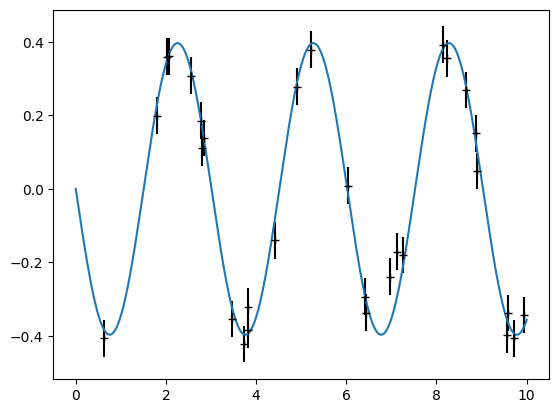

In [12]:
init_values = {"mass": 0.022, "period": 3.01, "error": rv_err.magnitude}
init_model = rv_model(over_time, init_values)

plt.errorbar(time, rv_obs.magnitude,  yerr=rv_err.magnitude, fmt="+k")
plt.plot(over_time, init_model, "C0")

In [13]:
sampler = infer.MCMC(
    infer.NUTS(model, init_strategy=infer.init_to_value(values=init_values)),
    num_warmup=2000,
    num_samples=10000,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(6), time, y=rv_obs.magnitude)

sample: 100%|██████████| 12000/12000 [00:02<00:00, 5174.78it/s, 7 steps of size 6.48e-01. acc. prob=0.93]


/Users/lgarcia/mambaforge/envs/jaxoplanet_docs/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3522: UserWarning: The unit of a Quantity is stripped when downcasted to an array.
  y = np.asarray(y, dtype=object)


<ErrorbarContainer object of 3 artists>

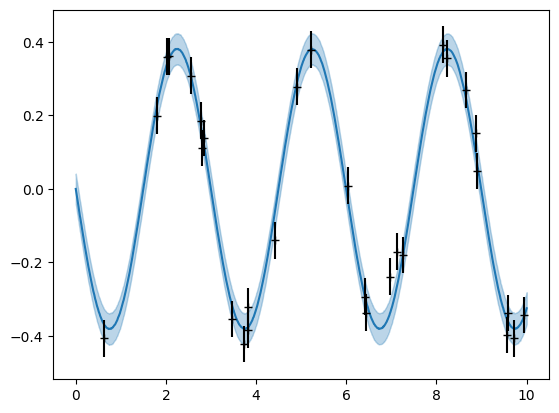

In [14]:
samples = sampler.get_samples()
posterior_rvs = infer.Predictive(model, samples)(jax.random.PRNGKey(0), over_time)["y"]

plt.plot(over_time, posterior_rvs.mean(0), "C0")
plt.fill_between(
    over_time,
    *np.percentile(posterior_rvs, [16, 84], axis=0),
    alpha=0.3,
    color="C0",
)
plt.errorbar(time, rv_obs, yerr=rv_err.magnitude, fmt="+k")